# Import necessary files

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pycolmap
from pathlib import Path
from tqdm import tqdm
import cv2
import open3d as o3d
import shutil
import piexif
from collections import defaultdict

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Create artifacts folder

In [2]:
# Set your image directory path here
IMAGE_DIR = "./notebooks/path_gen/data/images"
LABEL_DIR = "./notebooks/path_gen/data/labels"

# Output directories
OUTPUT_DIR = "./notebooks/path_gen/colmap_output"
FEATURE_DIR = os.path.join(OUTPUT_DIR, "features")
DATABASE_PATH = os.path.join(OUTPUT_DIR, "database.db")
RECONSTRUCTION_PATH = os.path.join(OUTPUT_DIR, "reconstruction")

In [3]:
def reset_output_dir(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)

reset_output_dir(OUTPUT_DIR)

# Create output directories if they don't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(FEATURE_DIR, exist_ok=True)
os.makedirs(RECONSTRUCTION_PATH, exist_ok=True)

# Load images and bounding boxes

In [4]:
# Update to use list of dicts
image_bbox_list = []
for file in os.listdir(LABEL_DIR):
    if file.endswith('.txt'):
        img_name = file.replace('.txt', '.jpeg')
        with open(os.path.join(LABEL_DIR, file), 'r') as f:
            bboxes = []
            for line in f:
                class_id, x, y, w_, h_ = map(float, line.strip().split())
                bboxes.append({"class_id": int(class_id), "x_center": x, "y_center": y, "width": w_, "height": h_})
        image_bbox_list.append((img_name, bboxes))

# Show sample image and bounding box
image_bbox_list[0]

('DJI_20250424162216_0039_V.jpeg',
 [{'class_id': 0,
   'x_center': 0.7221645712852478,
   'y_center': 0.1672336459159851,
   'width': 0.013310084119439125,
   'height': 0.019981101155281067},
  {'class_id': 1,
   'x_center': 0.7444412112236023,
   'y_center': 0.13333305716514587,
   'width': 0.0143280029296875,
   'height': 0.023051893338561058},
  {'class_id': 2,
   'x_center': 0.7548139691352844,
   'y_center': 0.24250593781471252,
   'width': 0.01247236505150795,
   'height': 0.018559571355581284},
  {'class_id': 3,
   'x_center': 0.7715803980827332,
   'y_center': 0.09431783854961395,
   'width': 0.015780009329319,
   'height': 0.02486799657344818},
  {'class_id': 4,
   'x_center': 0.8087140321731567,
   'y_center': 0.19195270538330078,
   'width': 0.013852497562766075,
   'height': 0.019718129187822342},
  {'class_id': 5,
   'x_center': 0.7226647138595581,
   'y_center': 0.08798243850469589,
   'width': 0.01470002718269825,
   'height': 0.026248397305607796},
  {'class_id': 6,
  

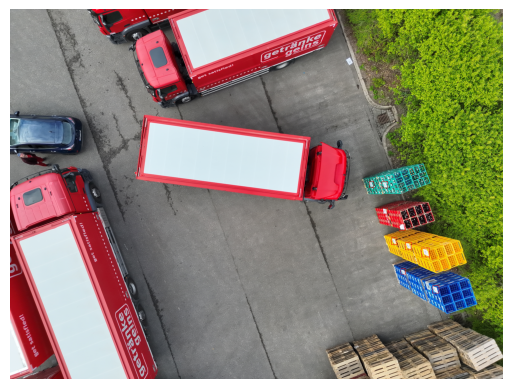

In [5]:

# Update bbox usage in show_sample_image
def show_sample_image(index):
    img_path = os.path.join(IMAGE_DIR, image_bbox_list[index][0])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    for bbox in image_bbox_list[index][1]:
        x, y, bw, bh = bbox["x_center"], bbox["y_center"], bbox["width"], bbox["height"]
        x1, y1 = int((x - bw/2) * w), int((y - bh/2) * h)
        x2, y2 = int((x + bw/2) * w), int((y + bh/2) * h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

show_sample_image(2)

In [6]:
# Extract SIFT features
print("Extracting features...")
pycolmap.set_random_seed(0)
pycolmap.extract_features(DATABASE_PATH, IMAGE_DIR)

Extracting features...


: 

: 

: 

In [ ]:
# Match Sift Features
pycolmap.match_exhaustive(DATABASE_PATH)

# Reconstruction of 3D scene
Through this reconstruction step, we can get the intrinsics and extrinsics matrix of a camera.

In [9]:
# Incremental Reconstruction of Scene
def incremental_mapping_with_pbar(database_path, image_path, sfm_path):
    num_images = pycolmap.Database(database_path).num_images
    
    # Create a progress bar placeholder
    pbar = tqdm(total=num_images, desc="Images registered:")
    pbar.update(0)
    
    # Define callback functions that update the progress bar
    def initial_pair_callback():
        pbar.update(2)
    
    def next_image_callback():
        pbar.update(1)
    
    try:
        reconstructions = pycolmap.incremental_mapping(
            database_path,
            image_path,
            sfm_path,
            initial_image_pair_callback=initial_pair_callback,
            next_image_callback=next_image_callback,
        )
    finally:
        # Ensure the progress bar is closed even if an exception occurs
        pbar.close()
    
    return reconstructions

In [ ]:
recs = incremental_mapping_with_pbar(DATABASE_PATH, IMAGE_DIR, RECONSTRUCTION_PATH)
reconstruction = recs[0]

Images registered:: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


In [7]:
# If you already have a reconstruction, you can load it
reconstruction = pycolmap.Reconstruction(os.path.join(RECONSTRUCTION_PATH, "0"))

# Visualization
This helps us debug early on mistakes in the 3d world reconstruction.

In [38]:
# Prepare point cloud with colors
xyz = np.array([p.xyz for p in reconstruction.points3D.values()])
rgb = np.array([p.color for p in reconstruction.points3D.values()]) / 255.0
pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(xyz))
pcd.colors = o3d.utility.Vector3dVector(rgb)

frames = []
for image in reconstruction.images.values():
    R = image.cam_from_world.rotation.matrix()
    t = -R.T @ image.cam_from_world.translation
    frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)

    print(f"Image: {image.name}\nRotation:\n{R}\nTranslation:\n{t}\n")
    frame.translate(t)
    frame.rotate(R.T, center=t)
    frames.append(frame)

o3d.visualization.draw_geometries([pcd] + frames)

Image: DJI_20250424162216_0039_V.jpeg
Rotation:
[[ 0.23213301 -0.68916766  0.68641256]
 [ 0.97267684  0.16175307 -0.1665404 ]
 [ 0.00374492  0.70631713  0.70788565]]
Translation:
[-0.21029659 -1.14515228  2.10832865]

Image: DJI_20250424162217_0040_V.jpeg
Rotation:
[[ 0.0172221  -0.70918403  0.70481303]
 [ 0.99982395  0.00696433 -0.01742317]
 [ 0.00744768  0.70498902  0.70917912]]
Translation:
[-1.79359152 -0.92682309  2.2197795 ]

Image: DJI_20250424162218_0041_V.jpeg
Rotation:
[[-0.0021991  -0.71046121  0.70373293]
 [ 0.99996665 -0.00709729 -0.00404034]
 [ 0.0078651   0.70370057  0.71045313]]
Translation:
[-3.35643585 -0.99320604  2.19877987]

Image: DJI_20250424162219_0042_V.jpeg
Rotation:
[[ 0.00433386 -0.71099554  0.70318316]
 [ 0.99996367 -0.00207973 -0.0082658 ]
 [ 0.00733938  0.70319344  0.7109607 ]]
Translation:
[-4.88028696 -1.13442003  2.09379641]

Image: DJI_20250424162252_0071_V.jpeg
Rotation:
[[ 0.06204654 -0.71816864  0.69309742]
 [ 0.71335872  0.51759435  0.4724568 ]
 [

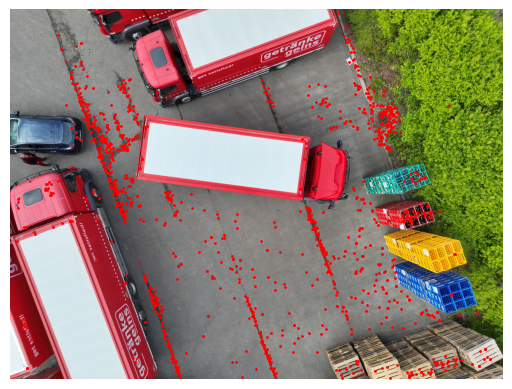

In [11]:
# Take a random image and point2D to visualize
image_id = 3
image = reconstruction.images[image_id]
camera = reconstruction.cameras[image.camera_id]

# Get points 2D that can map to 3D from the image
observations = image.get_observation_points2D()

# Get 2D points from observations
points_2d = [obs.xy for obs in observations if obs.point3D_id != -1]

# Plot the 2D points on the image
img_path = os.path.join(IMAGE_DIR, image.name)
img = Image.open(img_path)
plt.imshow(img)
plt.scatter(*zip(*points_2d), color='red', s=1)  # Red points
plt.axis('off')
plt.show()

# Triangulation from barcode bounding box

In [29]:
# Sample Image and Bounding Box
image_bbox_list

[('DJI_20250424162216_0039_V.jpeg',
  [{'class_id': 0,
    'x_center': 0.7221645712852478,
    'y_center': 0.1672336459159851,
    'width': 0.013310084119439125,
    'height': 0.019981101155281067},
   {'class_id': 1,
    'x_center': 0.7444412112236023,
    'y_center': 0.13333305716514587,
    'width': 0.0143280029296875,
    'height': 0.023051893338561058},
   {'class_id': 2,
    'x_center': 0.7548139691352844,
    'y_center': 0.24250593781471252,
    'width': 0.01247236505150795,
    'height': 0.018559571355581284},
   {'class_id': 3,
    'x_center': 0.7715803980827332,
    'y_center': 0.09431783854961395,
    'width': 0.015780009329319,
    'height': 0.02486799657344818},
   {'class_id': 4,
    'x_center': 0.8087140321731567,
    'y_center': 0.19195270538330078,
    'width': 0.013852497562766075,
    'height': 0.019718129187822342},
   {'class_id': 5,
    'x_center': 0.7226647138595581,
    'y_center': 0.08798243850469589,
    'width': 0.01470002718269825,
    'height': 0.0262483973

## Triangulation Helper
From points in 2d image planes, draw 3D lines then get candidate points where the line intersect each other.

In [ ]:
import random

# Find rays from image
def triangulate_lines(points_2d, intrinsics, extrinsics):
    lines = []
    for pts, K, ext in zip(points_2d, intrinsics, extrinsics):
        R, t = ext[:3, :3], ext[:3, 3]
        C = -R.T @ t
        for p in pts:
            p_h = np.array([p[0], p[1], 1.0])
            ray_cam = np.linalg.inv(K) @ p_h
            ray_world = R.T @ ray_cam
            ray_world /= np.linalg.norm(ray_world)
            lines.append((C, ray_world))
    return lines

def fit_point_to_rays(rays):
    A = []
    b = []
    for C, d in rays:
        d = d / np.linalg.norm(d)
        I = np.eye(3)
        A.append(I - np.outer(d, d))
        b.append((I - np.outer(d, d)) @ C)
    A = np.sum(A, axis=0)
    b = np.sum(b, axis=0)
    return np.linalg.lstsq(A, b, rcond=None)[0]  # least-squares point

In [44]:
# Group lines by class
class_to_lines = {}

for (filename, bboxes) in image_bbox_list:
    image = reconstruction.find_image_with_name(filename)
    ext = image.cam_from_world.matrix()
    R, t = ext[:3, :3], ext[:3, 3]
    C = -R.T @ t
    camera = reconstruction.cameras[image.camera_id]
    K = camera.calibration_matrix()

    for bbox in bboxes:
        class_id = bbox['class_id']
        x = bbox['x_center'] * camera.width
        y = bbox['y_center'] * camera.height
        p_h = np.array([x, y, 1.0])
        ray_cam = np.linalg.inv(K) @ p_h
        ray_world = R.T @ ray_cam
        ray_world /= np.linalg.norm(ray_world)

        class_to_lines.setdefault(class_id, []).append((C, ray_world))

# Solve 3D point for each class
class_to_3d = {cls: fit_point_to_rays(lines) for cls, lines in class_to_lines.items()}

best_points = np.array([point.reshape(3, 1) for point in class_to_3d.values()])

best_points

array([[[-2.1677423 ],
        [ 1.91712742],
        [ 9.46722819]],

       [[-2.26061868],
        [ 1.41283852],
        [ 8.70890171]],

       [[-1.59535388],
        [ 2.05046953],
        [ 9.89487237]],

       [[-2.87409873],
        [ 1.91569166],
        [ 9.96218268]],

       [[-1.58253799],
        [ 1.09527522],
        [ 8.94319397]],

       [[-2.65786873],
        [ 1.76320042],
        [ 9.08945347]],

       [[-2.93707945],
        [ 2.32263112],
        [ 9.55585615]],

       [[-3.5165862 ],
        [ 2.58137025],
        [ 9.43834819]],

       [[ 0.25394259],
        [-1.69154141],
        [ 0.79123379]],

       [[-1.60526251],
        [ 1.30853879],
        [ 9.17363399]],

       [[-2.50107596],
        [ 1.46201136],
        [ 8.02405258]]])

# Visualize Best Points Candidates

In [43]:
# Create Open3D geometries
geometries = []
colors = {}

ray_length = 15.0  # extension length

for class_id, lines in class_to_lines.items():
    color = [random.random(), random.random(), random.random()]
    colors[class_id] = color
    for C, d in lines:
        line = o3d.geometry.LineSet(
            points=o3d.utility.Vector3dVector([C, C + d * ray_length]),
            lines=o3d.utility.Vector2iVector([[0, 1]])
        )
        line.colors = o3d.utility.Vector3dVector([color])
        geometries.append(line)

# Add points
for class_id, point in class_to_3d.items():
    sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.1)
    sphere.translate(point)
    sphere.paint_uniform_color(colors[class_id])
    geometries.append(sphere)

# Visualize
o3d.visualization.draw_geometries([pcd] + frames + geometries)


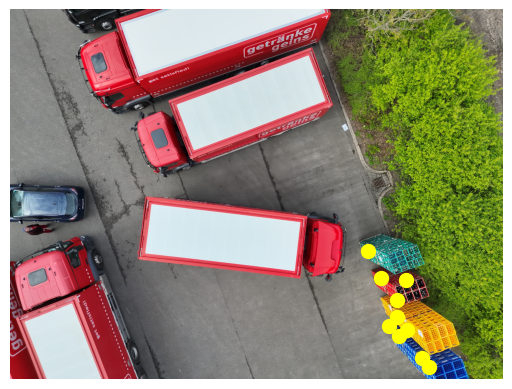

In [47]:
image_id = 4
image = reconstruction.images[image_id]
camera = reconstruction.cameras[image.camera_id]

K = camera.calibration_matrix()
Rt = image.cam_from_world.matrix()
R = Rt[:3, :3]
t = Rt[:3, 3]

projected_points = []
for pt in best_points:
    pt = pt.flatten()
    pt_cam = R @ pt + t
    if pt_cam[2] <= 0:
        continue
    pt_img = K @ (pt_cam / pt_cam[2])
    x, y = pt_img[0], pt_img[1]
    if 0 <= x < camera.width and 0 <= y < camera.height:
        projected_points.append((x, y))

img_path = os.path.join(IMAGE_DIR, image.name)
img = Image.open(img_path)

plt.imshow(img)
if projected_points:
    plt.scatter(*zip(*projected_points), color='yellow', s=100)
plt.axis('off')
plt.show()


# Get Drone Coordinates

In [56]:
# Assume ground normal is [0, 0, 1]
ground_normal = np.array([0, 0, 1])

# Fit general plane ax + by + cz + d = 0
A = np.hstack([best_points.reshape(-1, 3), np.ones((len(best_points), 1))])
_, _, V = np.linalg.svd(A)
plane = V[-1, :]  # [a, b, c, d]
plane /= np.linalg.norm(plane[:3])

In [57]:
# Project points onto the plane
best_points_proj = []
normal = plane[:3]
d = plane[3]

for pt in best_points.reshape(-1, 3):
    dist = (np.dot(normal, pt) + d) / np.linalg.norm(normal)
    pt_proj = pt - dist * (normal / np.linalg.norm(normal))
    best_points_proj.append(pt_proj)

best_points_proj = np.array(best_points_proj).reshape(-1, 3, 1)

In [61]:
# Plane normal
plane_normal = plane[:3]
plane_normal /= np.linalg.norm(plane_normal)

# Shift points
best_points_shifted = best_points_proj + 0.5 * (plane_normal.reshape(3, 1))

In [62]:
# Create a large plane manually
plane_mesh = o3d.geometry.TriangleMesh.create_box(width=2.0, height=2.0, depth=0.001)
plane_mesh.translate([-1.0, -1.0, 0.0])
plane_mesh.paint_uniform_color([0.8, 0.8, 0.8])

# Align the plane normal
z_axis = np.array([0, 0, 1])
rotation_axis = np.cross(z_axis, plane_normal)
rotation_angle = np.arccos(np.clip(np.dot(z_axis, plane_normal), -1.0, 1.0))
if np.linalg.norm(rotation_axis) > 1e-6:
    rotation_axis /= np.linalg.norm(rotation_axis)
    R = o3d.geometry.get_rotation_matrix_from_axis_angle(rotation_axis * rotation_angle)
    plane_mesh.rotate(R, center=(0, 0, 0))

plane_mesh.translate(plane_center)

# Create original points
pcd_original = o3d.geometry.PointCloud()
pcd_original.points = o3d.utility.Vector3dVector(best_points.reshape(-1, 3))
pcd_original.paint_uniform_color([1, 0, 0])

# Create shifted points
pcd_shifted = o3d.geometry.PointCloud()
pcd_shifted.points = o3d.utility.Vector3dVector(best_points_shifted.reshape(-1, 3))
pcd_shifted.paint_uniform_color([0, 0, 1])

# Visualize
o3d.visualization.draw_geometries([plane_mesh, pcd_original, pcd_shifted])

# Convert from world coordinate to GPS coordinate

In [63]:
def estimate_similarity_transform(source, target):
    src_mean = source.mean(axis=0)
    tgt_mean = target.mean(axis=0)

    src_centered = source - src_mean
    tgt_centered = target - tgt_mean

    H = src_centered.T @ tgt_centered
    U, _, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1] *= -1
        R = Vt.T @ U.T

    scale = np.sum(tgt_centered * (src_centered @ R)) / np.sum(src_centered**2)
    t = tgt_mean - scale * (R @ src_mean)

    return scale, R, t

import random

def ransac_similarity(source, target, num_iter=1000, threshold=3.0):
    best_inliers = []
    best_model = None

    for _ in range(num_iter):
        idx = random.sample(range(len(source)), 3)
        src_sample = source[idx]
        tgt_sample = target[idx]

        try:
            scale, R, t = estimate_similarity_transform(src_sample, tgt_sample)
        except:
            continue

        transformed = scale * (source @ R.T) + t
        errors = np.linalg.norm(transformed - target, axis=1)
        inliers = np.where(errors < threshold)[0]

        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_model = (scale, R, t)

    if best_model is None:
        raise RuntimeError("RANSAC failed to find a valid model")

    # Refit using all inliers
    scale, R, t = estimate_similarity_transform(source[best_inliers], target[best_inliers])
    return scale, R, t

In [65]:
# From GPS to ECEF
def transform_gps_to_ecef(lat, lon, alt):
    # Convert GPS coordinates to ECEF
    # WGS84 constants
    a = 6378137.0  # Semi-major axis
    e_sq = 6.69437999014e-3  # Square of eccentricity

    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    N = a / np.sqrt(1 - e_sq * np.sin(lat_rad)**2)

    x = (N + alt) * np.cos(lat_rad) * np.cos(lon_rad)
    y = (N + alt) * np.cos(lat_rad) * np.sin(lon_rad)
    z = (N * (1 - e_sq) + alt) * np.sin(lat_rad)
    return np.array([x, y, z])

# From world space to ECEF
def transform_proj_to_ecef(point, scale, R, t):
    point = np.asarray(point).reshape(3,)  # from (3,1) to (3,)
    return scale * (R @ point) + t

def transform_ecef_to_gps(x, y, z):
    a = 6378137.0
    e_sq = 6.69437999014e-3

    b = np.sqrt(a**2 * (1 - e_sq))
    ep = np.sqrt((a**2 - b**2) / b**2)
    p = np.sqrt(x**2 + y**2)
    th = np.arctan2(a * z, b * p)
    lon = np.arctan2(y, x)
    lat = np.arctan2(z + ep**2 * b * np.sin(th)**3, p - e_sq * a * np.cos(th)**3)
    N = a / np.sqrt(1 - e_sq * np.sin(lat)**2)
    alt = p / np.cos(lat) - N

    lat = np.degrees(lat)
    lon = np.degrees(lon)
    return lat, lon, alt

def transform_proj_to_gps(point, scale, R, t):
    ecef = transform_proj_to_ecef(point, scale, R, t)
    return transform_ecef_to_gps(*ecef)

In [66]:
def get_image_gps_from_file(image, image_dir):
    image_path = Path(image_dir) / image.name
    exif = piexif.load(str(image_path))
    gps = exif.get("GPS", {})

    def dms_to_deg(dms, ref):
        deg = dms[0][0]/dms[0][1]
        min = dms[1][0]/dms[1][1]
        sec = dms[2][0]/dms[2][1]
        sign = -1 if ref in ['S', 'W'] else 1
        return sign * (deg + min/60 + sec/3600)

    lat = dms_to_deg(gps[piexif.GPSIFD.GPSLatitude], gps[piexif.GPSIFD.GPSLatitudeRef].decode())
    lon = dms_to_deg(gps[piexif.GPSIFD.GPSLongitude], gps[piexif.GPSIFD.GPSLongitudeRef].decode())
    alt = gps.get(piexif.GPSIFD.GPSAltitude, (0,1))
    alt = alt[0]/alt[1]

    return lat, lon, alt

In [71]:
# Test GPS extraction
image_id = 1
image = reconstruction.images[image_id]
camera = reconstruction.cameras[image.camera_id]
test_projection = image.projection_center()

lat, lon, alt = get_image_gps_from_file(image, IMAGE_DIR)
ecef = transform_gps_to_ecef(lat, lon, alt)
ecef

array([4174894.57936376,  849410.4403778 , 4731358.62360867])

In [67]:
proj_centers = []
ecef_coords = []

for image in reconstruction.images.values():
    if not reconstruction.is_image_registered(image.image_id):
        continue
    try:
        lat, lon, alt = get_image_gps_from_file(image, IMAGE_DIR)
    except:
        continue
    proj_centers.append(image.projection_center())
    ecef_coords.append(transform_gps_to_ecef(lat, lon, alt))

proj_centers = np.array(proj_centers)
ecef_coords = np.array(ecef_coords)

print(f"Projection centers: {proj_centers.shape}, ECEF coordinates: {ecef_coords.shape}")

Projection centers: (10, 3), ECEF coordinates: (10, 3)


In [68]:
scale, R, t = ransac_similarity(proj_centers, ecef_coords, threshold=3)
print(f"Scale: {scale}, Rotation:\n{R}, Translation:\n{t}")

Scale: 1.395817695175956, Rotation:
[[ 0.72612108 -0.31324822 -0.61206513]
 [ 0.16275451 -0.78658389  0.59564818]
 [-0.6680263  -0.53212907 -0.52017258]], Translation:
[4174896.88795869  849405.89989463 4731358.88183329]


In [72]:
ecef_point = transform_proj_to_ecef(test_projection, scale, R, t)
ecef_point - ecef  # Should be close to each other

array([ 0.79494465, -1.57806427, -0.225904  ])

In [103]:
lat, lon, alt = transform_ecef_to_gps(*ecef_point)
print(f"Latitude: {lat}, Longitude: {lon}, Altitude: {alt}")

Latitude: 49.09934661880369, Longitude: 12.180987492353058, Altitude: 486.9322567367926


# Piecing everything together

In [70]:
best_points_gps = np.zeros((len(best_points_shifted), 3))

for i, pt in enumerate(best_points):
    lat, lon, alt = transform_proj_to_gps(pt, scale, R, t)
    best_points_gps[i] = [lat, lon, alt]

best_points_gps[:5]  # Show first 5 points

array([[ 48.18934706,  11.50027761, 555.89711058],
       [ 48.18934817,  11.50027424, 557.14400372],
       [ 48.18933992,  11.50028166, 555.34136205],
       [ 48.189356  ,  11.50028399, 555.4110091 ],
       [ 48.18933973,  11.50028175, 557.22338325]])